# #1. Multi-layer Perceptron을 수행하고, 이해하기

# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
# import libraries
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

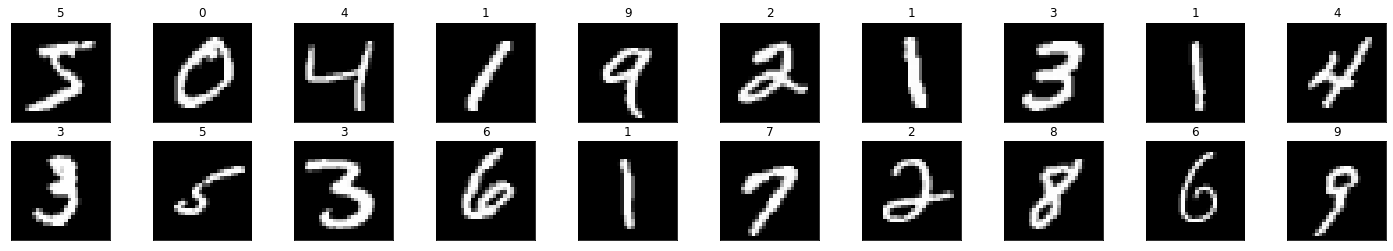

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

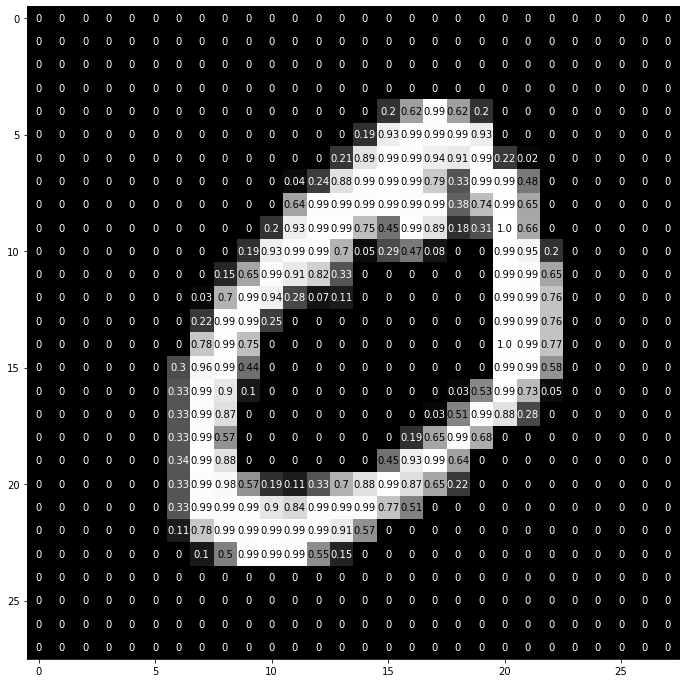

In [4]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> 10)
        self.fc2 = nn.Linear(512, 10)


    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        return x

# initialize the NN
model_base = Net()
print(model_base)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [6]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model_base.parameters(), lr=0.1)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss


In [7]:
def train_model(model, criterion, optimizer, n_epochs, device=None) : #{
    global train_loader

    model.train()    # prep model for training

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        epoch_accuracy = 0
        
        ###################
        # train the model #
        ###################
        for data, target in train_loader:
            # move data and target to device
            if device is not None :
                data = data.to(device)
                target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)

            # calculate accuracy
            _, predicted = torch.max(output, dim=1)
            accuracy = (predicted == target).sum().item()
            epoch_accuracy += accuracy        
            
        # print training statistics 
        # calculate average loss over an epoch
        train_loss = train_loss/len(train_loader.dataset)
        # calculate acuracy over an epoch
        epoch_accuracy /= len(train_data)    

        print('Epoch: {} \tTraining Loss: {:.6f},\tTrain Accuracy : {:.6f}'.format(
            epoch+1, 
            train_loss,
            epoch_accuracy
            ))

    #}
#}

In [8]:
# Train model_base
n_epochs = 10
train_model(model_base, criterion, optimizer, n_epochs)

Epoch: 1 	Training Loss: 0.403987,	Train Accuracy : 0.893717
Epoch: 2 	Training Loss: 0.301326,	Train Accuracy : 0.916117
Epoch: 3 	Training Loss: 0.287319,	Train Accuracy : 0.920367
Epoch: 4 	Training Loss: 0.279707,	Train Accuracy : 0.922350
Epoch: 5 	Training Loss: 0.274627,	Train Accuracy : 0.923733
Epoch: 6 	Training Loss: 0.270876,	Train Accuracy : 0.924683
Epoch: 7 	Training Loss: 0.267930,	Train Accuracy : 0.925883
Epoch: 8 	Training Loss: 0.265519,	Train Accuracy : 0.926333
Epoch: 9 	Training Loss: 0.263488,	Train Accuracy : 0.926800
Epoch: 10 	Training Loss: 0.261729,	Train Accuracy : 0.927383


---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [9]:
def test_model(model, criterion, device=None) : #{
    global test_loader

    # initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # prep model for *evaluation*

    for data, target in test_loader:
        # move data and target to device
        if device is not None :
            data = data.to(device)
            target = target.to(device)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # calculate and print avg test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))    
#}

In [10]:
# Test model_base
test_model(model_base, criterion)

Test Loss: 0.287572

Test Accuracy of     0: 98% (962/980)
Test Accuracy of     1: 98% (1116/1135)
Test Accuracy of     2: 86% (889/1032)
Test Accuracy of     3: 89% (906/1010)
Test Accuracy of     4: 91% (899/982)
Test Accuracy of     5: 92% (821/892)
Test Accuracy of     6: 93% (897/958)
Test Accuracy of     7: 89% (919/1028)
Test Accuracy of     8: 84% (823/974)
Test Accuracy of     9: 93% (940/1009)

Test Accuracy (Overall): 91% (9172/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

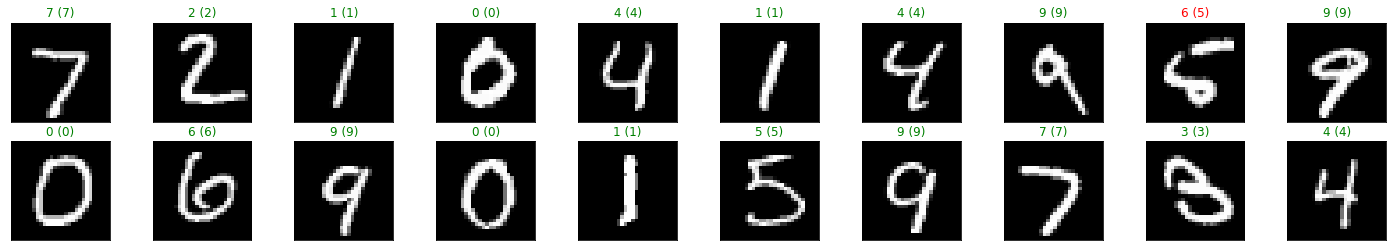

In [11]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model_base(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# #2. Multilayer Perceptron 성능 향상 방법 제안 및 결과 확인
## Multilayer Perceptron 성능 향상 방법 1  : 모델을 더 깊게 만든다.
- 기본 모델의 경우 fc1만 사용하였고, 최종 아웃풋이 512임을 확인할 수 있다.
- 따라서, 모델에 fc2를 추가해 target과 class 개수를 맞춘다.
- 또한, 모델을 더 깊게 만듦으로써 성능을 향상시킬 수 있다.

<br>

### 모델 구조 변경 내용
- Hidden Layer를 총 3개를 쌓았다.
  (784 -> 512 -> 256 -> 128 -> 10)
- 그 외의 Loss Function(Criterion)과 Optimizer, n_epochs는 동일하게 사용했다.

<br>

### 성능 비교
- epoch 10일 때의 train loss와 train accuracy 비교  
    - model_base   :: Loss: 0.261676, Accuracy : 0.927333
    - model_deeper :: Loss: 0.014404, Accuracy : 0.995433

- test loss와 test accuracy 비교
    - model_base   :: Loss: 0.292896, Accuracy : 91%
    - model_deeper :: Loss: 0.084452, Accuracy : 98%

In [12]:
## Define the NN architecture
class DeeperNet(nn.Module):
    def __init__(self):
        super(DeeperNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        # linear layer (n_hidden -> 10)
        self.fc4 = nn.Linear(128, 10)


    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

# initialize the NN
model_deeper = DeeperNet()
print(model_deeper)

DeeperNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [13]:
## Specify loss and optimization functions

# specify loss function
criterion_deeper = nn.CrossEntropyLoss()

# specify optimizer
optimizer_deeper = torch.optim.SGD(model_deeper.parameters(), lr=0.1)

In [14]:
# Train model_deeper
n_epochs = 10
train_model(model_deeper, criterion_deeper, optimizer_deeper, n_epochs)

Epoch: 1 	Training Loss: 0.310972,	Train Accuracy : 0.902867
Epoch: 2 	Training Loss: 0.093691,	Train Accuracy : 0.971783
Epoch: 3 	Training Loss: 0.060376,	Train Accuracy : 0.981550
Epoch: 4 	Training Loss: 0.042601,	Train Accuracy : 0.987217
Epoch: 5 	Training Loss: 0.031562,	Train Accuracy : 0.990167
Epoch: 6 	Training Loss: 0.026660,	Train Accuracy : 0.991633
Epoch: 7 	Training Loss: 0.021857,	Train Accuracy : 0.993383
Epoch: 8 	Training Loss: 0.020118,	Train Accuracy : 0.993817
Epoch: 9 	Training Loss: 0.017606,	Train Accuracy : 0.994517
Epoch: 10 	Training Loss: 0.015860,	Train Accuracy : 0.994883


In [15]:
# Test model_deeper
test_model(model_deeper, criterion)

Test Loss: 0.094619

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 99% (1130/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 98% (997/1010)
Test Accuracy of     4: 96% (950/982)
Test Accuracy of     5: 96% (865/892)
Test Accuracy of     6: 96% (924/958)
Test Accuracy of     7: 96% (997/1028)
Test Accuracy of     8: 95% (935/974)
Test Accuracy of     9: 98% (996/1009)

Test Accuracy (Overall): 97% (9772/10000)


## Multilayer Perceptron 성능 향상 방법 2
- Learning Rate를 0.1에서 0.01로 변경했다.
- Epoch을 10에서 20으로 증가했다.
- 모델의 구조는 동일하게 사용했다.

<br>

### 성능 비교
- epoch 10일 때의 train loss와 train accuracy 비교  
    - model_base     :: Loss: 0.261676, Accuracy : 0.927333
    - model_modified :: Loss: 0.072104, Accuracy : 0.980483

- test loss와 test accuracy 비교
    - model_base     :: Loss: 0.292896, Accuracy : 91%
    - model_modified :: Loss: 0.088973, Accuracy : 97%
- 
Training Loss: 0.072104,	Train Accuracy : 0.980483
Loss: 0.088973, Accuracy : 97%

In [16]:
## Define the NN architecture
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> 10)
        self.fc2 = nn.Linear(512, 10)


    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

# initialize the NN
model_base2 = Net2()
print(model_base2)

Net2(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [17]:
## Specify loss and optimization functions

# specify loss function
criterion2 = nn.CrossEntropyLoss()

# specify optimizer
optimizer2 = torch.optim.SGD(model_base2.parameters(), lr=0.01)

In [18]:
# Train model_base
n_epochs = 20
train_model(model_base2, criterion2, optimizer2, n_epochs)

Epoch: 1 	Training Loss: 0.661190,	Train Accuracy : 0.846783
Epoch: 2 	Training Loss: 0.320842,	Train Accuracy : 0.910117
Epoch: 3 	Training Loss: 0.272671,	Train Accuracy : 0.923517
Epoch: 4 	Training Loss: 0.239336,	Train Accuracy : 0.932750
Epoch: 5 	Training Loss: 0.212858,	Train Accuracy : 0.940317
Epoch: 6 	Training Loss: 0.191093,	Train Accuracy : 0.946033
Epoch: 7 	Training Loss: 0.172965,	Train Accuracy : 0.951583
Epoch: 8 	Training Loss: 0.157672,	Train Accuracy : 0.956033
Epoch: 9 	Training Loss: 0.144649,	Train Accuracy : 0.959783
Epoch: 10 	Training Loss: 0.133461,	Train Accuracy : 0.962800
Epoch: 11 	Training Loss: 0.123756,	Train Accuracy : 0.965383
Epoch: 12 	Training Loss: 0.115231,	Train Accuracy : 0.967800
Epoch: 13 	Training Loss: 0.107709,	Train Accuracy : 0.970133
Epoch: 14 	Training Loss: 0.101038,	Train Accuracy : 0.972200
Epoch: 15 	Training Loss: 0.095074,	Train Accuracy : 0.973883
Epoch: 16 	Training Loss: 0.089729,	Train Accuracy : 0.975450
Epoch: 17 	Traini

In [19]:
# Test model_base
test_model(model_base2, criterion2)

Test Loss: 0.089761

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 98% (1122/1135)
Test Accuracy of     2: 97% (1006/1032)
Test Accuracy of     3: 97% (986/1010)
Test Accuracy of     4: 97% (956/982)
Test Accuracy of     5: 97% (874/892)
Test Accuracy of     6: 97% (931/958)
Test Accuracy of     7: 96% (996/1028)
Test Accuracy of     8: 96% (936/974)
Test Accuracy of     9: 96% (970/1009)

Test Accuracy (Overall): 97% (9748/10000)


## Multilayer Perceptron 성능 향상 방법 3
- 이 외에도 모델에 Dropout이나 BatchNormalization Layer를 추가하여 Overfitting을 방지하면서 성능을 향상시킬 수 있다.
- 또한, SGD 이외에 Adam과 같은 다른 Optimizer를 사용했을 때, 더 높은 성능을 도출할 수 있다.  
  위의 예제에서 Adam Optimizer를 사용했으나, 성능이 좋지 않아 코드로 추가하지는 않았다.

# #3. 2번의 모델을 GPU 연산으로 학습
1. device를 GPU로 설정 한다.
2. .to()를 이용해서 모델을 GPU로 옮긴다.
3. .to()를 이용해서 학습하는 data를 GPU로 옮긴다.

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [21]:
# initialize the NN
model_gpu = DeeperNet()
model_gpu.to(device)
print(model_gpu)

DeeperNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [22]:
## Specify loss and optimization functions

# specify loss function
criterion_gpu = nn.CrossEntropyLoss()
# specify optimizer
optimizer_gpu = torch.optim.SGD(model_gpu.parameters(), lr=0.1)

In [23]:
# Train model_deeper
n_epochs = 10
train_model(model_gpu, criterion_gpu, optimizer_gpu, n_epochs, device)

Epoch: 1 	Training Loss: 0.322476,	Train Accuracy : 0.900783
Epoch: 2 	Training Loss: 0.096622,	Train Accuracy : 0.971350
Epoch: 3 	Training Loss: 0.061054,	Train Accuracy : 0.981883
Epoch: 4 	Training Loss: 0.041262,	Train Accuracy : 0.987450
Epoch: 5 	Training Loss: 0.034333,	Train Accuracy : 0.989000
Epoch: 6 	Training Loss: 0.027587,	Train Accuracy : 0.991333
Epoch: 7 	Training Loss: 0.023688,	Train Accuracy : 0.992383
Epoch: 8 	Training Loss: 0.019815,	Train Accuracy : 0.993483
Epoch: 9 	Training Loss: 0.016616,	Train Accuracy : 0.994183
Epoch: 10 	Training Loss: 0.017234,	Train Accuracy : 0.994617


In [24]:
# Test model_deeper
test_model(model_gpu, criterion_gpu, device)

Test Loss: 0.093414

Test Accuracy of     0: 99% (974/980)
Test Accuracy of     1: 99% (1130/1135)
Test Accuracy of     2: 97% (1010/1032)
Test Accuracy of     3: 96% (972/1010)
Test Accuracy of     4: 97% (960/982)
Test Accuracy of     5: 99% (884/892)
Test Accuracy of     6: 97% (931/958)
Test Accuracy of     7: 97% (1000/1028)
Test Accuracy of     8: 97% (946/974)
Test Accuracy of     9: 97% (980/1009)

Test Accuracy (Overall): 97% (9787/10000)
